In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
df = pd.read_csv('ddb_output.csv')
df.rename(columns={'humidity.S': 'humidity',
                   'temperature.S':'temperature',
                   'timestamp.S':'timestamp'},inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
#df.reset_index(drop=True,inplace=True)
df.sort_values(by='timestamp',inplace=True)
df

,humidity,temperature,timestamp
0,54.00,18.04,2023-04-21 12:36:04.168213
1,54.00,18.13,2023-04-21 12:36:07.120651
2,54.00,18.01,2023-04-21 12:36:10.007948
3,54.00,18.09,2023-04-21 12:36:12.959915
4,52.00,18.08,2023-04-21 15:48:08.632782
...,...,...,...
3041,56.35,21.63,2023-05-10 20:30:04.178828
3042,56.91,21.57,2023-05-10 20:40:04.682990
3043,56.72,21.54,2023-05-10 20:50:04.106947
3044,56.77,21.50,2023-05-10 21:00:04.586745


In [4]:
fig = px.scatter(df, x="timestamp", y=["humidity","temperature"], title='All-time humidity and temperature in the grove!')
fig.show()

In [5]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
go.Scatter(x=df['timestamp'],y=df['temperature'], name="Temperature", mode='markers'),
secondary_y=False,
)

fig.add_trace(
go.Scatter(x=df['timestamp'],y=df['humidity'], name="Humidity", mode='markers'),
secondary_y=True,
)

fig.update_layout(
title_text="Temperature and humidity over time"
)

# Set x-axis title
fig.update_xaxes(title_text="Time")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Temperature</b>", title_font_color='blue', secondary_y=False)
fig.update_yaxes(title_text="<b>Humidity</b>", title_font_color='red', secondary_y=True)

In [6]:
df['date'] = df['timestamp'].map(lambda x: pd.Timestamp(x).date())

In [7]:
df_last_week = df[df['timestamp'] > str(pd.Timestamp('2023-05-1'))]

In [8]:
fig = px.box(df_last_week, x="date", y="temperature")
fig.show()

## Building a forecasting model 

In [27]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity','date'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')
df_temp.head()

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00


In [10]:
px.scatter(df_temp, x='timestamp', y='temperature', title='Temperature from 28 April to May 11th (~12 days)')

### Baseline - persistence forecast 1,2,4 hours in advance

In [11]:
df_temp

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00
...,...,...
2087,21.63,2023-05-10 20:30:00
2088,21.57,2023-05-10 20:40:00
2089,21.54,2023-05-10 20:50:00
2090,21.50,2023-05-10 21:00:00


In [12]:
# Test - to predict temperature 1,2,4 hours in advance

def persistence_n_hours(n):

    timestamps_n_hr = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x) + pd.Timedelta(hours=n))

    df_temp_n_hr_baseline = pd.DataFrame(list(zip(timestamps_n_hr,df_temp['temperature'])))
    df_temp_n_hr_baseline.rename(columns={0:'timestamp', 1:'value'},inplace=True)
    df_temp_n_hr_baseline['type'] = f'persist. {n}hrs'
    df_temp_n_hr_baseline = df_temp_n_hr_baseline[['value', 'timestamp', 'type']]
    df_temp_n_hr_baseline

    return df_temp_n_hr_baseline

persist_1_hr = persistence_n_hours(1)
persist_2_hr = persistence_n_hours(2)
persist_4_hr = persistence_n_hours(4)


In [13]:
df_temp['type'] = 'observation'
df_temp.rename(columns={'temperature':'value'},inplace=True)
df_temp

,value,timestamp,type
0,17.83,2023-04-28 08:25:00,observation
1,17.85,2023-04-28 08:25:00,observation
2,17.85,2023-04-28 08:30:00,observation
3,17.88,2023-04-28 08:30:00,observation
4,17.88,2023-04-28 09:20:00,observation
...,...,...,...
2087,21.63,2023-05-10 20:30:00,observation
2088,21.57,2023-05-10 20:40:00,observation
2089,21.54,2023-05-10 20:50:00,observation
2090,21.50,2023-05-10 21:00:00,observation


In [14]:
df_1_hour_forecast = pd.concat([df_temp, persist_2_hr], axis=0)



df_1_hour_forecast['timestamp'] = df_1_hour_forecast['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_1_hour_forecast.sort_values(by='timestamp',inplace=True)

df_1_hour_forecast_1_day = df_1_hour_forecast[ df_1_hour_forecast['timestamp'] > str(pd.Timestamp('2023-05-10')) ]

df_1_hour_forecast


,value,timestamp,type
0,17.83,2023-04-28 08:25:00,observation
1,17.85,2023-04-28 08:25:00,observation
2,17.85,2023-04-28 08:30:00,observation
3,17.88,2023-04-28 08:30:00,observation
4,17.88,2023-04-28 09:20:00,observation
...,...,...,...
2087,21.63,2023-05-10 22:30:00,persist. 2hrs
2088,21.57,2023-05-10 22:40:00,persist. 2hrs
2089,21.54,2023-05-10 22:50:00,persist. 2hrs
2090,21.50,2023-05-10 23:00:00,persist. 2hrs


In [15]:

px.scatter(df_1_hour_forecast_1_day, x='timestamp', y='value', color='type', title='Temperature from 28 April to May 11th (~12 days)')

In [16]:
df_1_hour_forecast['value'] = df_1_hour_forecast['value'].astype(float)

In [17]:
# This works but not where there's NaN

persistence_forecast_1_hr = df_1_hour_forecast.pivot_table(values='value', index='timestamp', columns='type').head(-20)
persistence_forecast_1_hr['rel_error'] = persistence_forecast_1_hr['observation'] - persistence_forecast_1_hr['persist. 2hrs']
persistence_forecast_1_hr['abs_error'] = abs(persistence_forecast_1_hr['observation'] - persistence_forecast_1_hr['persist. 2hrs'] )

persistence_forecast_1_hr

persistence_forecast_1_hr_errors = persistence_forecast_1_hr[['rel_error','abs_error']]
persistence_forecast_1_hr_errors.reset_index(inplace=True)

persistence_forecast_1_hr_errors = persistence_forecast_1_hr_errors.melt(id_vars='timestamp')
persistence_forecast_1_hr_errors

px.scatter(persistence_forecast_1_hr_errors, x='timestamp', y='value', color='type', title='Errors from a 1-hr persistence forecast')

In [36]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity','date'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp.set_index('timestamp',inplace=True)
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-10 20:30:00,21.63
2023-05-10 20:40:00,21.57
2023-05-10 20:50:00,21.54


In [ ]:
!pip install statsmodels

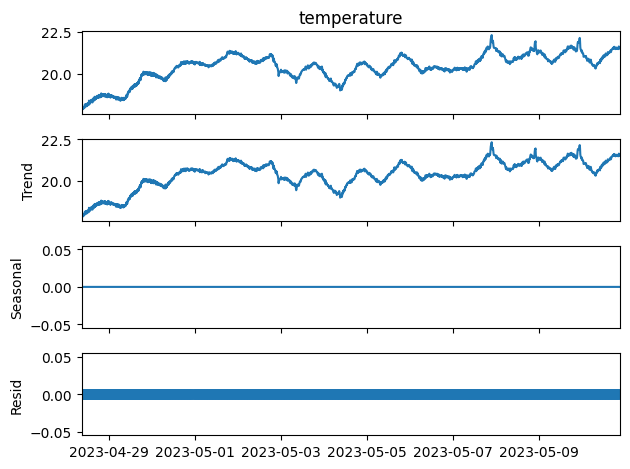

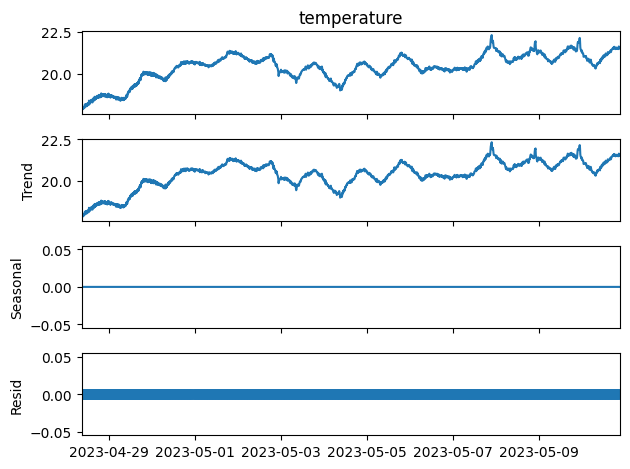

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df_temp['temperature'], period=1)
results.plot()

### Autocorrelation - test using Durbin-Watson test

In [19]:
# Keras - time series forecasting example 

# https://keras.io/examples/adsf/timeseries_weather_forecasting/